# 1. Importing libraries

In [ ]:
#basic libs
import numpy as np
import pandas as pd

#visualization libs
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="monokai",context="notebook",ticks=True,grid=True)

#warnings
import warnings
warnings.filterwarnings("ignore")

#deep learning libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping

#preprocessing and metrics
from sklearn import metrics,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

_________________________________________________________________________________________________

# 2. Importing the created dataset

In [2]:
#reading the data
df=pd.read_csv("finalized_stock_data.csv",index_col=False)
#renaming the column
df.rename(columns={"Unnamed: 0":"Date"},inplace=True)
#setting date as the index column
df.set_index("Date",inplace=True)
#displaying the dataset
df

,Open,High,Low,Close,Volume,compound,negative,neutral,positive
Date,,,,,,,,,
2001-05-22,0.428571,0.430893,0.417857,0.419643,412916000.0,-0.9907,0.134,0.800,0.066
2001-05-25,0.414286,0.415893,0.401786,0.406429,158743200.0,0.0772,0.000,0.606,0.394
2001-05-29,0.398571,0.401786,0.371607,0.383393,515989600.0,-0.9584,0.081,0.847,0.072
2001-05-30,0.370714,0.370714,0.344643,0.353214,777078400.0,-0.5713,0.073,0.850,0.077
2001-06-01,0.359464,0.376607,0.356786,0.373036,456075200.0,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...
2020-12-24,131.320007,133.460007,131.100006,131.970001,54930100.0,-0.9971,0.082,0.854,0.064
2020-12-28,133.990005,137.339996,133.509995,136.690002,124486200.0,-0.9997,0.126,0.789,0.085
2020-12-29,138.050003,138.789993,134.339996,134.869995,121047300.0,-0.9998,0.136,0.774,0.090


_________________________________________________________________________________________________________________

# 3. Data preprocessing for modelling

### 3.1 Splitting the data into features and target variables

In [3]:
#splitting the data into input and target variables
x=df
y=df["Close"]
#splitting the data into train set and test set
training_set=x.iloc[:4000].values
test_set=x.iloc[4000:].values

### 3.2 Scaling the data

In [4]:
#scaling the input features with the help of standard scaler
sc=MinMaxScaler()
training_set_scaled=sc.fit_transform(training_set)
test_set_scaled=sc.fit_transform(test_set)

### 3.3 Generating train and test data based on past 100 days 

In [5]:
# the model will look into past 100 timesteps predict the next feature and will continue to do so
length=100
#the training set creation
x_train=[]
y_train=[]
for i in range(length,len(training_set)):
    x_train.append(training_set_scaled[i-length:i,0])
    y_train.append(training_set_scaled[i,0])
#converting train set into array
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


# The testing set creation
x_test=[]
y_test=[]
for i in range(length,len(test_set)):
    x_test.append(test_set_scaled[i-length:i,0])
    y_test.append(test_set_scaled[i,0])
# converting test set into array
x_test,y_test=np.array(x_test),np.array(y_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [6]:
#checking the shape of the created datastructures
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((3900, 100, 1), (3900,), (823, 100, 1), (823,))

___________________________________________________________________________________________________

# 4. Modelling

The LSTM model will learn a function that maps a sequence of past observations as input to an output observation. ... We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned

### 4.1 Defining LSTM model architecture

In [7]:
# setting the model architecture
model=Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1], 1),activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True,activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=False,activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(1))
#printing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

### 4.2 Model fitting and compiling

In [8]:
# introducing early stopping if val loss doesn't go down for 4 iterations
es=EarlyStopping(monitor="val_loss",patience=4,mode="min")
#compiling
model.compile(optimizer="adam",loss="mse")
#fitting the model
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=22,shuffle=False,callbacks=[es])

Epoch 1/10
178/178 [==============================] - 118s 578ms/step - loss: 0.0031 - val_loss: 0.2557
Epoch 2/10
178/178 [==============================] - 111s 624ms/step - loss: 0.0100 - val_loss: 0.4239
Epoch 3/10
178/178 [==============================] - 118s 664ms/step - loss: 0.0132 - val_loss: 0.5261
Epoch 4/10
178/178 [==============================] - 127s 714ms/step - loss: 0.0203 - val_loss: 0.3414
Epoch 5/10
178/178 [==============================] - 106s 598ms/step - loss: 0.0174 - val_loss: 0.0490
Epoch 6/10
178/178 [==============================] - 45s 253ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 7/10
178/178 [==============================] - 44s 247ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/10
178/178 [==============================] - 44s 247ms/step - loss: 0.0015 - val_loss: 7.7501e-04
Epoch 9/10
178/178 [==============================] - 44s 248ms/step - loss: 0.0010 - val_loss: 8.9322e-04
Epoch 10/10
178/178 [==============================] - 44s 2

_______________________________________________________________________________________________________

### 4.3 comparing the validation and training loss

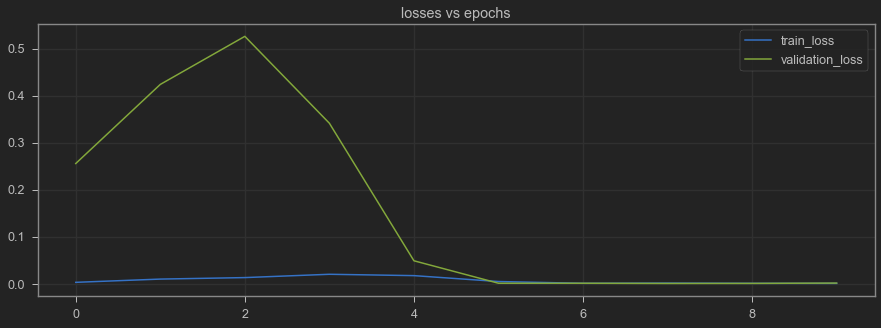

In [9]:
#creating the dataframe contaning the validation loss and  train_inver_transform
loss=pd.DataFrame(model.history.history)
plt.figure(figsize=(15,5))
plt.plot(loss)
plt.title("losses vs epochs")
plt.legend(["train_loss","validation_loss"])

# 5 Saving the model to the disk

In [11]:
#saving model to the disk as json file
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

#serialize weights to HDF5
model.save_weights("model.h5")
print("model saved to the disk")

model saved to the disk


______________________________________________________________________________________________________

# 6. Transforming the scaled data to it's original form

In [ ]:
#predicting through the model
pred=model.predict(x_test)

In [21]:
#checking the scales and comparing it with our closing price column
sc.scale_,df

(array([9.77278232e-03, 9.71675721e-03, 1.01173618e-02, 9.88704046e-03,
        2.62424487e-09, 5.00075011e-01, 7.75193798e+00, 7.19424460e+00,
        1.23456790e+01]),
                   Open        High         Low       Close       Volume  \
 Date                                                                      
 2001-05-22    0.428571    0.430893    0.417857    0.419643  412916000.0   
 2001-05-25    0.414286    0.415893    0.401786    0.406429  158743200.0   
 2001-05-29    0.398571    0.401786    0.371607    0.383393  515989600.0   
 2001-05-30    0.370714    0.370714    0.344643    0.353214  777078400.0   
 2001-06-01    0.359464    0.376607    0.356786    0.373036  456075200.0   
 ...                ...         ...         ...         ...          ...   
 2020-12-24  131.320007  133.460007  131.100006  131.970001   54930100.0   
 2020-12-28  133.990005  137.339996  133.509995  136.690002  124486200.0   
 2020-12-29  138.050003  138.789993  134.339996  134.869995  121047300

In [25]:
# the 4th column is "close" so we should scale our values by the 4th value(corresponding value) in the scale array
scale=1/9.88704046e-03
#scaling the predicted values
pred=pred*scale
#scaling the test values
test=y_test*scale

In [26]:
#creating the dataframe of test values vs predicted values
test_vs_pred=pd.DataFrame(columns=["test","pred"])
test_vs_pred["test"]=test
test_vs_pred["pred"]=pred.flatten()
#checking the dataframne created
test_vs_pred.head(10)

,test,pred
0,2.194347,4.580080
1,2.693512,4.169977
2,2.715751,3.836868
3,2.547717,3.627636
4,2.807181,3.529917
5,2.745403,3.536793
6,2.651503,3.610896
7,2.787411,3.704805
8,2.982631,3.796498
9,3.190203,3.884518


____________________________________________________________________________________________________

# 7. Model evaluation

Text(700, 22, 'MSE:15.95')

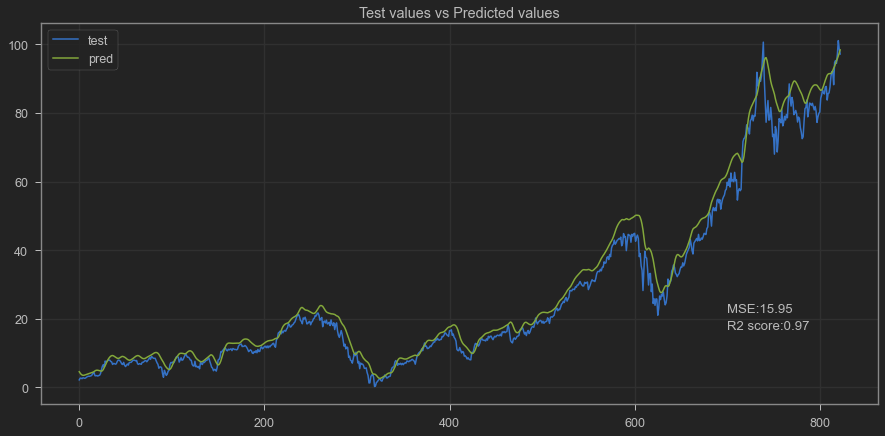

In [33]:

#the lineplot
plt.figure(figsize=(15,7))
plt.plot(test_vs_pred)
plt.title("Test values vs Predicted values")
plt.legend(["test","pred"])
#calculating the losses
r2=np.round(r2_score(test,pred),2)
mse=np.round(mean_squared_error(test,pred),2)
#incorporating the losses in the plot
plt.text(x=700,y=17,s="R2 score:{}".format(r2))
plt.text(x=700,y=22,s="MSE:{}".format(mse))

# 8. Saving the predictions to the disk

In [34]:
test_vs_pred.to_csv("final predictions.csv")

_________________________________________________________________________________________________________________________________________